In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mplcyberpunk as mplnk

In [65]:
import tensorflow as tf
import tfx
import keras
from keras import Model, layers, metrics, optimizers
from tfx.dsl.components.base.base_component import BaseComponent
from tfx.dsl.components.base.base_executor import BaseExecutor
from tfx.components.example_gen.csv_example_gen.component import CsvExampleGen
from tfx.components.example_gen.csv_example_gen.executor import Executor
from tfx.orchestration.pipeline import Pipeline
from tfx.orchestration.local.local_dag_runner import LocalDagRunner

In [66]:
from pathlib import Path

In [67]:
from config import Config
from utils import DataLoader

In [64]:
CsvExampleGen(input_base=Config.Paths.TRAIN_DATA_FILE.as_posix())

CsvExampleGen(spec: <tfx.types.standard_component_specs.FileBasedExampleGenSpec object at 0x772cf79e9e70>, executor_spec: <tfx.dsl.components.base.executor_spec.BeamExecutorSpec object at 0x772cf79ebc70>, driver_class: <class 'tfx.components.example_gen.driver.FileBasedDriver'>, component_id: CsvExampleGen, inputs: {}, outputs: {'examples': OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)})

In [17]:
df = DataLoader().load_train_data()

In [46]:
plt.style.use('cyberpunk')

In [47]:
def plot_ratings_distribution(df):
    plt.figure(figsize=(10, 5))

    value_counts = df['rating'].value_counts()
    bars = plt.bar(x=value_counts.index, height=value_counts.values)
    percantages = value_counts / value_counts.sum() * 100

    font_dict = {
        'fontweight': 'normal',
        'fontfamily': 'sans-serif',
        'fontsize': 10,
        'color': 'white'
    }

    for bar, percantage in zip(bars, percantages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percantage:.2f}%', ha='center', va='bottom', fontdict=font_dict)

    mplnk.add_bar_gradient(bars)

    plt.xlabel('Rating', fontweight='bold')
    plt.show()

In [48]:
from utils.data_loader import DataLoader

In [49]:
df = DataLoader().load_train_data()

In [50]:
df.rename(columns={
    'user_id': 'user',
    'item_id': 'item'
}, inplace=True)

In [51]:
df

,user,item,rating
0,716,836,4
1,620,422,1
2,547,289,3
3,758,385,4
4,627,197,5
...,...,...,...
79995,336,628,3
79996,749,637,1
79997,758,313,4
79998,380,139,1


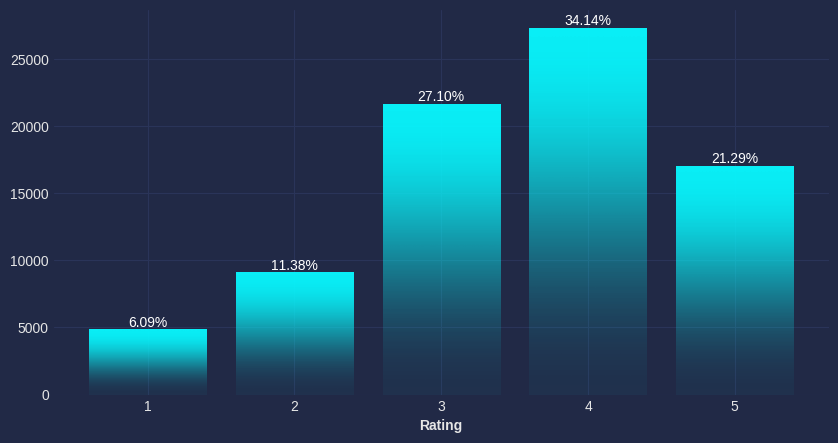

In [85]:
plot_ratings_distribution(df)

In [52]:
synth_df = pd.read_csv('../gen/synthetic_50000_500_1000.txt')

In [53]:
synth_df = synth_df.astype({'rating': 'int32'})

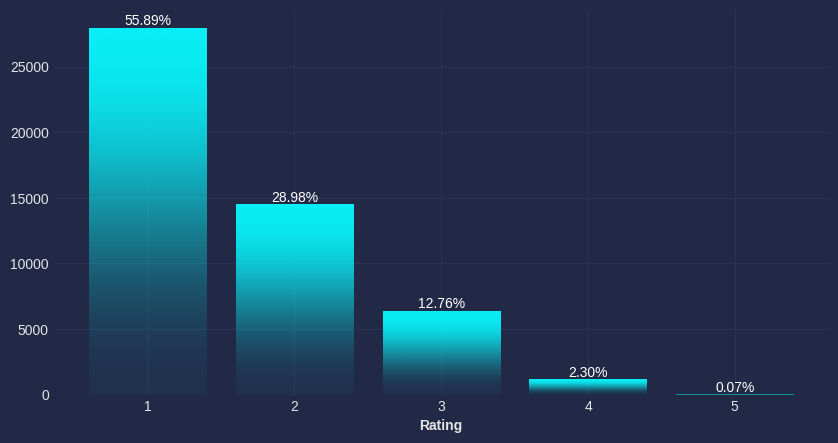

In [86]:
plot_ratings_distribution(synth_df)

In [54]:
synth_df

,user,item,rating
0,186,60,1
1,424,947,1
2,29,185,3
3,207,911,1
4,277,302,4
...,...,...,...
49995,133,95,2
49996,313,780,1
49997,25,46,1
49998,400,550,2


In [82]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.stats import f

class MANOVAMetric(metrics.Metric):
    def __init__(self, name='manova_metric', **kwargs):
        super(MANOVAMetric, self).__init__(name=name, **kwargs)
        self.real_data = []
        self.synthetic_data = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.real_data.append(y_true)
        self.synthetic_data.append(y_pred)

    def result(self):
        real_data = pd.concat(self.real_data, ignore_index=True)
        synthetic_data = pd.concat(self.synthetic_data, ignore_index=True)

        assert 'user' in real_data.columns and 'item' in real_data.columns and 'rating' in real_data.columns, \
            "Real data must contain 'user', 'item', and 'rating' columns"
        assert 'user' in synthetic_data.columns and 'item' in synthetic_data.columns and 'rating' in synthetic_data.columns, \
            "Synthetic data must contain 'user', 'item', and 'rating' columns"

        real_data = real_data.groupby(['user', 'item'], as_index=False).rating.mean()
        synthetic_data = synthetic_data.groupby(['user', 'item'], as_index=False).rating.mean()

        real_matrix = real_data.pivot(index='user', columns='item', values='rating').fillna(0)
        synthetic_matrix = synthetic_data.pivot(index='user', columns='item', values='rating').fillna(0)

        common_items = real_matrix.columns.intersection(synthetic_matrix.columns)
        real_matrix = real_matrix[common_items]
        synthetic_matrix = synthetic_matrix[common_items]

        # Check for identical data
        if real_matrix.equals(synthetic_matrix):
            return 1.0

        mean_real = real_matrix.mean(axis=0)
        mean_synthetic = synthetic_matrix.mean(axis=0)

        overall_mean = pd.concat([real_matrix, synthetic_matrix]).mean(axis=0)

        n_real = real_matrix.shape[0]
        n_synthetic = synthetic_matrix.shape[0]

        SS_between = n_real * np.outer(mean_real - overall_mean, mean_real - overall_mean) + \
                     n_synthetic * np.outer(mean_synthetic - overall_mean, mean_synthetic - overall_mean)

        SS_within_real = (real_matrix - mean_real).T @ (real_matrix - mean_real)
        SS_within_synthetic = (synthetic_matrix - mean_synthetic).T @ (synthetic_matrix - mean_synthetic)
        SS_within = SS_within_real + SS_within_synthetic

        # Use pseudo-inverse for numerical stability
        W_inv = np.linalg.pinv(SS_within)
        T2 = np.trace(np.dot(W_inv, SS_between))

        p = real_matrix.shape[1]
        df1 = p
        df2 = n_real + n_synthetic - p - 1
        F = (T2 * df2) / (df1 * (n_real + n_synthetic - df1 - 1))

        p_value = 1 - f.cdf(F, df1, df2)

        # Print intermediate results for diagnostics
        print(f"Mean Real: {mean_real}")
        print(f"Mean Synthetic: {mean_synthetic}")
        print(f"Overall Mean: {overall_mean}")
        print(f"SS Between: {SS_between}")
        print(f"SS Within: {SS_within}")
        print(f"T2: {T2}")
        print(f"F: {F}")
        print(f"p-value: {p_value}")

        return p_value

    def reset_states(self):
        self.real_data = []
        self.synthetic_data = []


In [83]:
manova = MANOVAMetric()
manova.update_state(df, synth_df)

In [84]:
manova.result()

Mean Real: item
1      1.500530
2      0.366914
3      0.199364
4      0.641569
5      0.259809
         ...   
995    0.080594
996    0.030753
997    0.022269
998    0.032874
999    0.022269
Length: 998, dtype: float64
Mean Synthetic: item
1      0.034595
2      0.042095
3      0.038333
4      0.064000
5      0.010000
         ...   
995    0.024600
996    0.018000
997    0.026000
998    0.040000
999    0.036000
Length: 998, dtype: float64
Overall Mean: item
1      0.992583
2      0.254364
3      0.143567
4      0.441441
5      0.173250
         ...   
995    0.061192
996    0.026334
997    0.023562
998    0.035343
999    0.027027
Length: 998, dtype: float64
SS Between: [[ 7.02174065e+02  1.55586289e+02  7.71325955e+01 ... -1.78695748e+00
  -3.41340371e+00 -6.57689750e+00]
 [ 1.55586289e+02  3.44744906e+01  1.70908822e+01 ... -3.95950371e-01
  -7.56334989e-01 -1.45729545e+00]
 [ 7.71325955e+01  1.70908822e+01  8.47288099e+00 ... -1.96294160e-01
  -3.74956439e-01 -7.22460711e-01]
 ...


1.0